# Final Project

In this notebook, we explore locations and their ratings

## Load Libraries

In [2]:
# !pip install beautifulsoup4 # uncomment to install beautifulsoup4 library

from bs4 import BeautifulSoup, element
import folium
from geopy.geocoders import Nominatim
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import urllib.request
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests # library to handle requests
from sklearn.cluster import KMeans

## Introduction / Business Problem

The client wants to start a new Taco Bell franchise and wants to choose a good location. Typically this involves determining the overlap between a franchise's target customer and the location's demographics. Instead, we can try and leverage data from existing franchise locations using Foursquare API. As a simple model, we pull the rating for franchise locations in the client's general area of interest ("near" Los Angeles).

## Data

The data initially consists of Taco Bell locations near the city of Los Angeles. Each entry will have the restaurant's location (latitude and longitude) as well as it's rating. We will try to predict ratings using the location data (using KNN regression). It may be necessary to also pull data from other franchises 

In [19]:
# Load Credentials from a file
with open("secret.json", "r") as f:
    secret = json.load(f)
    
CLIENT_ID = secret["CLIENT_ID"]
CLIENT_SECRET =secret["CLIENT_SECRET"]
VERSION = '20180605'
LIMIT = 200

In [43]:
def get_nearby_venues(search_term, latitude, longitude, radius=500):
    url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'
    url = url + f'&ll={latitude},{longitude}&intent=browse&radius={radius}&query={search_term}&limit={LIMIT}'

    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
    except:
        results = []
        
    data = []
    for result in results:
        venue = result['venue']
        
        venue_id = venue['id']
        name = venue['name']
        lat = venue['location']['lat']
        lng = venue['location']['lng']
        city = venue['location']['city']
        
        data.append([venue_id, name, lat, lng, city])
        
    return data

In [50]:
# Los Angeles extends 44 miles north-south and 29 miles east-west.
# But we'll collect as many Taco Bell locations nearby as possible.

LA_lat, LA_lng = (34.052235, -118.243683) # latitude and longitude of Los Angeles

data = get_nearby_venues("Taco Bell", LA_lat, LA_lng)

df = pd.DataFrame(data, columns=["ID", "Name", "Latitude", "Longitude", "City"])

df.head()

,ID,Name,Latitude,Longitude,City
0,4c192a016a21c9b60d23ca97,Taco Bell/Pizza Hut,34.036341,-118.257495,Los Angeles
1,4b96eef0f964a520b8ee34e3,Taco Bell/KFC,34.047415,-118.207097,Los Angeles
2,4bf60608004ed13a4fe141a0,Taco Bell,34.069499,-118.277301,Los Angeles
3,4b6b8de9f964a520990f2ce3,Taco Bell,34.079886,-118.259858,Los Angeles
4,4bbd3db1593fef3b134f0356,Taco Bell,34.026572,-118.276245,Los Angeles


In [56]:
def get_rating(venue_ID):
    url = f'https://api.foursquare.com/v2/venues/{venue_ID}?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'

    try:
        rating = requests.get(url).json()["response"]['venue']['rating']
    except:
        rating = float('nan')
    
    return rating

In [57]:
df["rating"] = df["ID"].map(get_rating)

In [64]:
df.head()

,ID,Name,Latitude,Longitude,City,rating
0,4c192a016a21c9b60d23ca97,Taco Bell/Pizza Hut,34.036341,-118.257495,Los Angeles,5.7
1,4b96eef0f964a520b8ee34e3,Taco Bell/KFC,34.047415,-118.207097,Los Angeles,7.0
2,4bf60608004ed13a4fe141a0,Taco Bell,34.069499,-118.277301,Los Angeles,6.4
3,4b6b8de9f964a520990f2ce3,Taco Bell,34.079886,-118.259858,Los Angeles,5.6
4,4bbd3db1593fef3b134f0356,Taco Bell,34.026572,-118.276245,Los Angeles,6.7


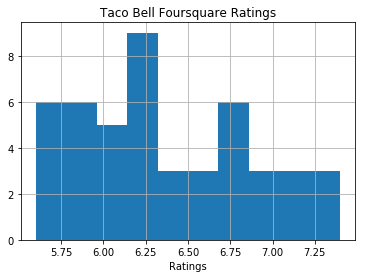

In [65]:
import matplotlib.pyplot as plt

df["rating"].hist()
plt.title("Taco Bell Foursquare Ratings")
plt.xlabel("Ratings")
plt.show()

## To Be Continued...